# Recurrent Networks for Textual Data Processing <br>
Loading the necessary packages <br>
Loading the data (IMDB dataset)<br>
Development of a Vanilla RNN model<br>
Development of a Bidirectional LSTM RNN model<br>

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from keras import layers
from keras.layers import SimpleRNN, Dense, Activation, Embedding, LSTM, Bidirectional
from keras.utils import pad_sequences
from keras.datasets import imdb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Loading the data (IMDB)

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data






In [52]:
(X_train,Y_train), (X_test, Y_test) = imdb.load_data(path = "imdb.npz",
                                    num_words = None,
                                    skip_top = 0,
                                    maxlen = None,
                                    seed = 113,
                                    start_char = 1,
                                    oov_char = 2,
                                    index_from = 3)

In [53]:
print("X_train: ",X_train.shape)
print("Y_train: ",Y_train.shape)
print("X_test: ",X_test.shape)
print("Y_test: ",Y_test.shape)

print("Existing classes: ", np.unique(Y_train))

X_train:  (25000,)
Y_train:  (25000,)
X_test:  (25000,)
Y_test:  (25000,)
Existing classes:  [0 1]


In [54]:
unique,  cc = np.unique(Y_train, return_counts = True)
print("Class distribution (training): ", dict(zip(unique,cc)))

Class distribution (training):  {0: 12500, 1: 12500}


In [55]:
unique,  cc = np.unique(Y_test, return_counts = True)
print("Class distribution (test): ", dict(zip(unique,cc)))

Class distribution (test):  {0: 12500, 1: 12500}


# Examples of Reviews (Sentences)

In [56]:
# obtaining the dictionary (id --> word)
dictionary = imdb.get_word_index() 
num_words = len(dictionary) 
print("Total number of words in the dictionary: ", num_words)

Total number of words in the dictionary:  88584


In [57]:
# Some words (10 most frequent)
for (word, id) in dictionary.items(): 
    if id <= 10: print(id, word)

10 i
9 it
6 is
8 in
4 of
3 a
7 br
1 the
2 and
5 to


In [58]:
def Decode(idx = 1):
    reverse_index = dict([(id,word) for (word, id) in dictionary.items()])
    sentence = " ".join([reverse_index.get(i - 3, "!") for i in X_train[idx]])
    return sentence

In [59]:
# Example of sentence (ids)
idx = 5 
sentence = Decode(idx) 
print("Ids: ", np.array(X_train[idx])-3) # subtraction of 3 - initial encoding 
print("Sentence: ", sentence) 
print("Length: ", len(X_train[idx])) 
print("Class: ", Y_train[idx])

Ids:  [   -2   775   125    71     9   627   160    12     1  1763  7979  1048
 43219    29    82   153    42    37   145   136   118   661   662     7
     7  1358   170     1   746 86585    13  3801     5     1   223    62
     9    40   124    21 15341     7     7]
Sentence:  ! begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br
Length:  43
Class:  0


# Preprocessing
Padding, dictionary reduction, and embedding dimension

In [60]:
# Reducing the number of words in the dictionary
# to reduce the number of parameters in the model
num_words = 5000
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=num_words)

maxlen = 100 
embedding = 16

In [61]:
# Maximum sentence length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print(X_train[5])
decoded_review = Decode(5)

# Words outside the dictionary (absent | >num_words)
# are replaced by oov_char (2)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]


# Model 01: Vanilla RNN

## Model Definition

In [62]:
model01 = keras.Sequential()
model01.add(Input(shape=(len(X_train[0]),)))
model01.add(Embedding(num_words, embedding, input_length=len(X_train[0])))
model01.add(SimpleRNN(10, return_sequences=True))
model01.add(SimpleRNN(10, return_sequences=False))
model01.add(Dense(1, activation="sigmoid"))

# Model Summary
model01.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (None, 100, 10)             │             270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,491 (314.42 KB)

 Trainable params: 80,491 (314.42 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
tf.keras.utils.plot_model(model01, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Model01 Training

In [64]:
model01.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model01.fit(X_train, Y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6604 - loss: 0.6027 - val_accuracy: 0.8096 - val_loss: 0.4331
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8311 - loss: 0.3962 - val_accuracy: 0.8272 - val_loss: 0.3977
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8648 - loss: 0.3330 - val_accuracy: 0.8296 - val_loss: 0.3813
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8916 - loss: 0.2768 - val_accuracy: 0.8324 - val_loss: 0.3924
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9123 - loss: 0.2366 - val_accuracy: 0.8252 - val_loss: 0.4044
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9309 - loss: 0.1947 - val_accuracy: 0.8364 - val_loss: 0.4330
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9479 - loss: 0.1533 - val_accuracy: 0.8344 - val_loss: 0.4711
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9624 - loss: 0.1143 - val_accu

# Evaluation

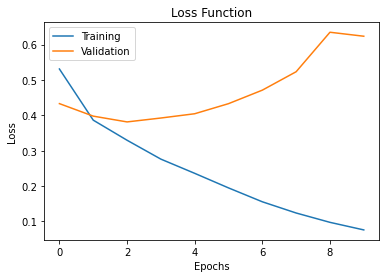

In [65]:
plt.figure()
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss Function")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

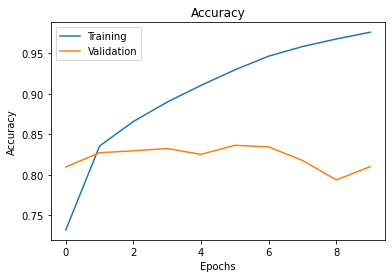

In [66]:
plt.figure()
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Accuracy on the test set

In [67]:
score = model01.evaluate(X_test, Y_test)
print("Final Accuracy: %", score[1]*100)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8117 - loss: 0.6055
Final Accuracy: % 81.5119981765747


# Confusion Matrix

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


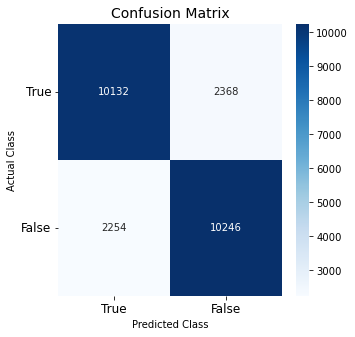

True Positive: 10132
True Negative: 10246
False Positive: 2368
False Negative: 2254


In [68]:
y_pred = model01.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test, y_pred)
df1 = pd.DataFrame(columns=["True", "False"], index=["True", "False"], data=cm)

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df1, annot=True, cmap="Blues", fmt='.0f', ax=ax)
plt.xlabel("Predicted Class")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("Actual Class")
plt.title("Confusion Matrix", size=14)
plt.show()

print("True Positive:", cm[0, 0])
print("True Negative:", cm[1, 1])
print("False Positive:", cm[0, 1])
print("False Negative:", cm[1, 0])